In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd

# Rasterstats contains the zonalstatistics function 
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

In [ ]:
######### USER #########
#select domain
domain = 'WY'

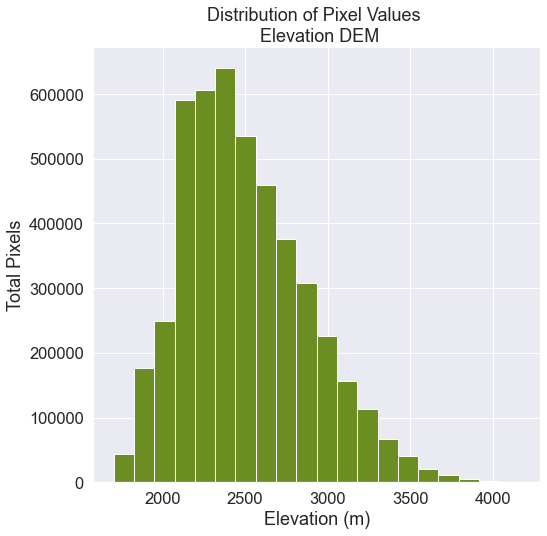

In [4]:
# raster path
raster_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain'.tif'

#fig paths 
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

#station path 
station_path = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_sites.geojson'
#Aragon2/CSOdata/
#Aragon2/CSOdmn/
#Aragon2/CSOfigs/

#https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/
#raster_path = '/nfs/attic/dfh/Aragon2/DEM_WY_new.tif'
raster_path = '/nfs/attic/dfh/Aragon2/Notebooks/DEM_WY_res100_WGS84.tif'

with rio.open(raster_path) as sjer_lidar_chm_src:
    # Masked = True sets no data values to np.nan if they are in the metadata
    SJER_chm_data = sjer_lidar_chm_src.read(1, masked=True)
    sjer_chm_meta = sjer_lidar_chm_src.profile

# Explore the data by plotting a histogram with earthpy
ax=ep.hist(SJER_chm_data,
        figsize=(8,8),
        colors="olivedrab",
        xlabel="Elevation (m)",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n Elevation DEM")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [14]:
raster = rio.open(raster_path)
raster.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 1868,
 'height': 2475,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0008983152841195215, 0.0, -111.15573662638135,
        0.0, -0.0008983152841195215, 44.586082496704215)}

In [5]:
# EXPLORE: View summary statistics of canopy height model
# Notice the mean value with 0's included in the data
print('Mean:', np.nanmean(SJER_chm_data))
print('Max:', np.nanmax(SJER_chm_data))
print('Min:', np.nanmin(SJER_chm_data))

Mean: 2499.997617935241
Max: 4160
Min: 1705


In [18]:
# CLEANUP: Set CHM values of 0 to NAN (no data or not a number)
SJER_chm_data[SJER_chm_data == 0] = np.nan

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(SJER_chm_data))
print('Max:', np.nanmax(SJER_chm_data))
print('Min:', np.nanmin(SJER_chm_data))

ValueError: cannot convert float NaN to integer

In [6]:
SJER_plots_points = gpd.read_file(station_path)

type(SJER_plots_points)

SJER_plots_points.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (-110.44544 43.94019)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (-111.12803 44.50832)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (-109.79333 44.37667)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (-110.60973 42.96400)
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,607155.527746,4.839116e+06,POINT (-109.67021 43.69733)


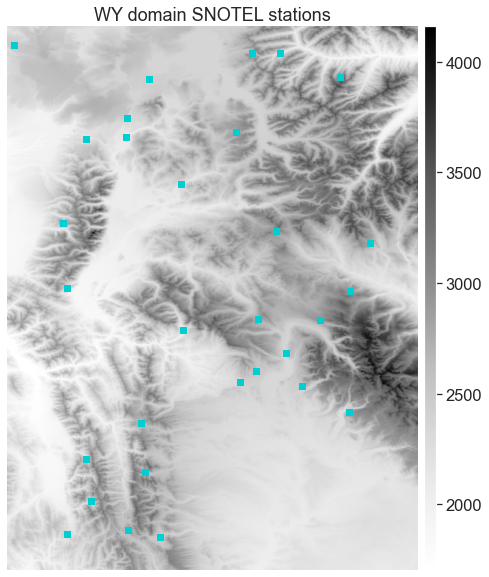

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(SJER_chm_data,
              extent=plotting_extent(sjer_lidar_chm_src), # Set spatial extent 
              cmap='Greys',
              title="WY domain SNOTEL stations",
              scale=False,
              ax=ax)

SJER_plots_points.plot(ax=ax,
                       marker='s',
                       markersize=45,
                       color='darkturquoise')
ax.set_axis_off()
plt.show()

In [8]:
# Extract zonal stats
sjer_tree_heights = rs.zonal_stats(station_path,
                                   SJER_chm_data,
                                   nodata=-999,
                                   affine=sjer_chm_meta['transform'],
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

# Turn extracted data into a pandas geodataframe
SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
SJER_lidar_height_df.head()

,geometry,code,longitude,latitude,name,elevation_m,easting,northing,min,max,mean,count,median
0,POINT (-110.44544 43.94019),314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,2161.0,2161.0,2161.0,1,2161.0
1,POINT (-111.12803 44.50832),347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,2492.0,2492.0,2492.0,1,2492.0
2,POINT (-109.79333 44.37667),350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,3021.0,3021.0,3021.0,1,3021.0
3,POINT (-110.60973 42.96400),353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,2705.0,2705.0,2705.0,1,2705.0
4,POINT (-109.67021 43.69733),379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,607155.527746,4.839116e+06,2669.0,2669.0,2669.0,1,2669.0


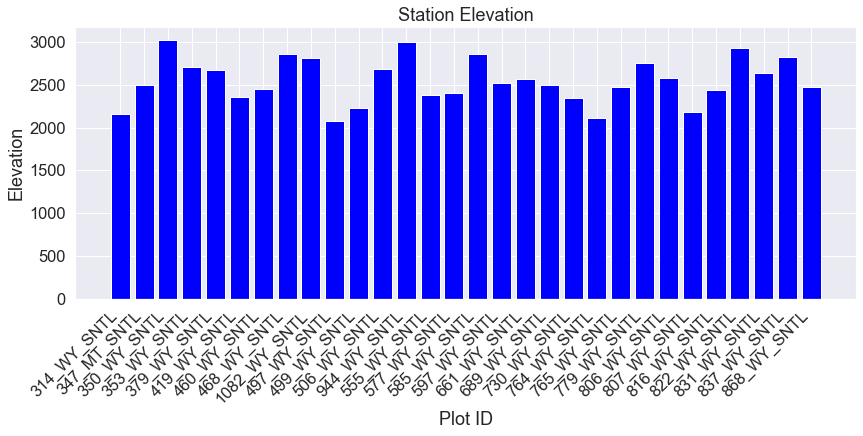

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.bar(SJER_lidar_height_df['code'],
       SJER_lidar_height_df['max'],
       color="blue")

ax.set(xlabel='Plot ID', ylabel='Elevation',
       title='Station Elevation')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [70]:
# Extract zonal stats
row,col = rio.transform.rowcol(SJER_chm_data,
                                   stn.geometry.centroid.x.values, stn.geometry.centroid.y.values)

ValueError: operands could not be broadcast together with shapes (7556,5871) (2,) 

In [60]:
coord = rio.transform.TransformMethodsMixin.index(SJER_chm_data,stn.geometry.centroid.x, stn.geometry.centroid.y)
coord

AttributeError: 'MaskedArray' object has no attribute 'transform'

In [52]:
import xarray as xr
from affine import Affine
da = xr.open_rasterio(raster_path)
transform = Affine.from_gdal(*da.attrs['transform'])
nx, ny = da.sizes['x'], da.sizes['y']
x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform

/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  


In [12]:
############################ 
stn = gpd.read_file(station_path)

with rio.open(raster_path) as src:
    rows, cols = rio.transform.rowcol(src.transform, stn.geometry.centroid.x, stn.geometry.centroid.y)
print(rows)
print(cols)

In [13]:
print(rows)
print(cols)

[719, 86, 233, 1805, 989, 2159, 1619, 1758, 898, 1383, 512, 1332, 1338, 1488, 420, 1205, 1572, 1640, 1190, 2313, 503, 2327, 2294, 120, 120, 241, 931, 2028, 483, 1971]
[790, 30, 1516, 607, 1653, 379, 1061, 1554, 253, 802, 357, 1142, 1422, 1268, 544, 1562, 1130, 1342, 270, 273, 541, 694, 550, 1112, 1244, 644, 1222, 628, 1040, 356]


In [11]:

stn = gpd.read_file(station_path)
stn.geometry.centroid.x.values

array([-110.4454422 , -111.12802887, -109.79332733, -110.60973358,
       -109.67021179, -110.81481934, -110.20230103, -109.75892639,
       -110.92783356, -110.43495178, -110.83435059, -110.12943268,
       -109.87815094, -110.01661682, -110.66628265, -109.7519989 ,
       -110.14006805, -109.94947052, -110.9125824 , -110.90989685,
       -110.66916656, -110.5320282 , -110.66148376, -110.1565094 ,
       -110.03807831, -110.57717133, -110.05780029, -110.59140015,
       -110.22122192, -110.83515167])

In [68]:
from __future__ import division
#from geopy.geocoders import Nominatim
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [75]:
filename = raster_path
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
data_array = gdal_data.ReadAsArray().astype(np.float)

row =[]
col =[]

gdata = gdal.Open(raster_path)
gt = gdata.GetGeoTransform()
data = gdata.ReadAsArray().astype(np.float)
for i in range(len(stn.geometry.centroid.x.values)):
    row.append(int((stn.geometry.centroid.x.values[i] - gt[0])/gt[1]))
    col.append(int((stn.geometry.centroid.y.values[i] - gt[3])/gt[5]))


print(row)
print(col)

[2414, 112, 4614, 1860, 5030, 1168, 3235, 4730, 787, 2450, 1102, 3480, 4328, 3861, 1669, 4754, 3445, 4088, 838, 848, 1660, 2122, 1686, 3389, 3789, 1970, 3722, 1922, 3171, 1100]
[2201, 284, 728, 5494, 3020, 6567, 4931, 5350, 2743, 4215, 1573, 4059, 4079, 4531, 1295, 3676, 4786, 4992, 3629, 7034, 1548, 7076, 6974, 387, 385, 753, 2846, 6169, 1487, 5996]


In [112]:
from osgeo import ogr, osr, gdal

def extract_point_from_raster(point, data_source, band_number=1):
    """Return floating-point value that corresponds to given point."""

    # Convert point co-ordinates so that they are in same projection as raster
    point_sr = point.GetSpatialReference()
    raster_sr = osr.SpatialReference()
    raster_sr.ImportFromWkt(data_source.GetProjection())
    transform = osr.CoordinateTransformation(point_sr, raster_sr)
    point.Transform(transform)

    # Convert geographic co-ordinates to pixel co-ordinates
    x, y = point.GetX(), point.GetY()
    forward_transform = Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)

    # Extract pixel value
    band = data_source.GetRasterBand(band_number)
    structval = band.ReadRaster(px, py, 1, 1, buf_type=gdal.GDT_Float32)
    result = struct.unpack('f', structval)[0]
    if result == band.GetNoDataValue():
        result = float('nan')
    return px, py, result

px,py,result = extract_point_from_raster(layer, raster_path, band_number=1)

AttributeError: type object 'object' has no attribute '__getattr__'

In [119]:
import affine
ds = gdal.Open(raster_path)

def retrieve_pixel_value(geo_coord, data_source):
    """Return floating-point value that corresponds to given point."""
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  \
        affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)
    pixel_coord = px, py

    data_array = np.array(data_source.GetRasterBand(1).ReadAsArray())
    return px, py, data_array[pixel_coord[0]][pixel_coord[1]]

px, py, value = retrieve_pixel_value((-110.44544219970703, 43.940189361572266), ds)
print(px,py,value)

2415 2201 2114


In [118]:
(-110.44544219970703, 43.940189361572266)[1]

43.940189361572266

In [90]:
from osgeo import gdal

driver = gdal.GetDriverByName('GTiff')
filename = raster_path #path to raster
dataset = gdal.Open(filename)
band = dataset.GetRasterBand(1)

cols = dataset.RasterXSize
rows = dataset.RasterYSize

transform = dataset.GetGeoTransform()

xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = -transform[5]

data = band.ReadAsArray(0, 0, cols, rows)

x = stn.geometry.centroid.x.values.tolist()
y = stn.geometry.centroid.y.values.tolist()
points_list=list(zip(a, b))

for point in points_list:
    col = int((point[0] - xOrigin) / pixelWidth)
    row = int((yOrigin - point[1] ) / pixelHeight)

    print (row,col, data[row][col])

2201 2414 2161
284 112 2493
728 4614 3012
5494 1860 2716
3020 5030 2669
6567 1168 2361
4931 3235 2448
5350 4730 2857
2743 787 2815
4215 2450 2077
1573 1102 2238
4059 3480 2682
4079 4328 2999
4531 3861 2374
1295 1669 2402
3676 4754 2863
4786 3445 2519
4992 4088 2565
3629 838 2506
7034 848 2342
1548 1660 2105
7076 2122 2470
6974 1686 2757
387 3389 2583
385 3789 2186
753 1970 2439
2846 3722 2925
6169 1922 2639
1487 3171 2827
5996 1100 2468


In [114]:
a = stn.geometry.centroid.x.values.tolist()
b = stn.geometry.centroid.y.values.tolist()
x=list(zip(a, b))
x

[(-110.44544219970703, 43.940189361572266),
 (-111.1280288696289, 44.50831985473633),
 (-109.79332733154297, 44.376670837402344),
 (-110.60973358154297, 42.9640007019043),
 (-109.67021179199219, 43.697330474853516),
 (-110.8148193359375, 42.64590072631836),
 (-110.20230102539062, 43.1309700012207),
 (-109.75892639160156, 43.006568908691406),
 (-110.9278335571289, 43.77933120727539),
 (-110.43495178222656, 43.342979431152344),
 (-110.8343505859375, 44.126121520996094),
 (-110.12943267822266, 43.38938903808594),
 (-109.8781509399414, 43.38331985473633),
 (-110.01661682128906, 43.249298095703125),
 (-110.6662826538086, 44.2086181640625),
 (-109.75199890136719, 43.50278091430664),
 (-110.14006805419922, 43.17387008666992),
 (-109.94947052001953, 43.11265182495117),
 (-110.91258239746094, 43.516868591308594),
 (-110.90989685058594, 42.50749969482422),
 (-110.6691665649414, 44.133609771728516),
 (-110.53202819824219, 42.49489974975586),
 (-110.66148376464844, 42.52516174316406),
 (-110.15650

In [100]:
geom = ogr.Open(station_path)

In [108]:
layer=geom.GetLayer(0)

In [110]:
n_feat = 0
for feat in layer:

    print (feat.GetField('NAME'))

    n_feat += 1


Base Camp
Black Bear
Blackwater
Blind Bull Sum
Burroughs Creek
Cottonwood Creek
East Rim Divide
Elkhart Park G.S.
Grand Targhee
Granite Creek
Grassy Lake
Gros Ventre Summit
Gunsight Pass
Kendall R.S.
Lewis Lake Divide
Little Warm
Loomis Park
New Fork Lake
Phillips Bench
Salt River Summit
Snake River Station
Snider Basin
Spring Creek Divide
Sylvan Lake
Sylvan Road
Thumb Divide
Togwotee Pass
Triple Peak
Two Ocean Plateau
Willow Creek


In [129]:
import pyproj

with rio.open(raster_path) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='epsg:4326')
    
    rows = []
    cols = []
    for i in range(len(x)):
        lon,lat = x[i]
        east,north = pyproj.transform(lonlat, utm, lon, lat)
        print(east)

    # What is the corresponding row and column in our image?
        row, col = src.index(east, north) # spatial --> image coordinates
        rows.append(row),cols.append(col)

/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


43.940189361572266
44.50831985473633
44.376670837402344
42.9640007019043
43.697330474853516
42.64590072631836
43.1309700012207
43.006568908691406
43.77933120727539
43.342979431152344
44.126121520996094
43.38938903808594
43.38331985473633
43.249298095703125
44.2086181640625
43.50278091430664
43.17387008666992
43.11265182495117
43.516868591308594
42.50749969482422
44.133609771728516
42.49489974975586
42.52516174316406
44.477638244628906
44.478248596191406
44.369171142578125
43.749019622802734
42.76393127441406
44.15177917480469
42.815128326416016


In [128]:
rows

[523035,
 525338,
 520835,
 523590,
 520420,
 524282,
 522215,
 520719,
 524663,
 523000,
 524347,
 521969,
 521122,
 521589,
 523780,
 520696,
 522005,
 521362,
 524611,
 524602,
 523790,
 523327,
 523764,
 522061,
 521661,
 523480,
 521728,
 523528,
 522279,
 524350]